**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd #for plots
from statistics import mean
from scipy.stats import mode
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute', metrics='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metrics = metrics

    def fit(self, X, y):
        self._y = y
        self._classes = list(set(y))
        if self.algorithm == 'brute':
            self._X_train = X
        elif self.algorithm == 'kd_tree':
            self._tree = KDTree(X, leaf_size=30)
        return self

    def predict(self, X):
        if self.algorithm == 'brute':
            distances = cdist(X, self._X_train, self.metrics)
            top = np.take_along_axis(np.array([self._y,]*X.shape[0]), 
                               np.argsort(distances, axis=1), axis=1)[:,:self.n_neighbors]
            y_pred = mode(top, axis=1)[0].ravel()
        elif self.algorithm == 'kd_tree':
            dist, ind = self._tree.query(X, k=self.n_neighbors)
            top = self._y[ind]
            y_pred = mode(top, axis=1).mode.ravel()
        return y_pred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metrics='euclidean', n_neighbors=2)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 559 µs, sys: 102 µs, total: 661 µs
Wall time: 586 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 34 µs, sys: 1 µs, total: 35 µs
Wall time: 37 µs


MyKNeighborsClassifier(algorithm='brute', metrics='euclidean', n_neighbors=2)

In [11]:
%time clf.predict(X_test)

CPU times: user 2.53 ms, sys: 1.2 ms, total: 3.73 ms
Wall time: 2.64 ms


array([1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 2, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 2.43 ms, sys: 1.33 ms, total: 3.76 ms
Wall time: 2.49 ms


array([1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 2, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 933 µs, sys: 1.19 ms, total: 2.12 ms
Wall time: 4.15 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 189 µs, sys: 27 µs, total: 216 µs
Wall time: 204 µs


MyKNeighborsClassifier(algorithm='kd_tree', metrics='euclidean', n_neighbors=2)

In [17]:
%time clf.predict(X_test)

CPU times: user 1.34 ms, sys: 471 µs, total: 1.82 ms
Wall time: 1.86 ms


array([1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1])

In [20]:
%time my_clf.predict(X_test)

CPU times: user 1.11 ms, sys: 60 µs, total: 1.17 ms
Wall time: 1.14 ms


array([1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1])

In [21]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [22]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [23]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [24]:
vectorizer = CountVectorizer(min_df=0.02, max_df=0.1, stop_words='english')
sentence_vectors = vectorizer.fit_transform(data)

vectorizer_tfidf = TfidfVectorizer(min_df=0.02, max_df=0.1, stop_words='english')
sentence_vectors_tfidf = vectorizer_tfidf.fit_transform(data)

In [25]:
sentence_vectors.toarray().shape

(11314, 431)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [26]:
def calc_accuracy_scores(sentence_vectors, metrics='euclidean'):
    accuracy_scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for neigh_num in range(1,10+1):
        cv = kf.split(sentence_vectors)
        clf_knn = MyKNeighborsClassifier(n_neighbors=neigh_num, metrics=metrics)
        score = cross_val_score(clf_knn, sentence_vectors.toarray(), target, 
                                cv=cv, scoring='accuracy', error_score='raise')
        accuracy_scores.append(mean(score))
    return accuracy_scores

In [27]:
accuracy_scores_eucl_count = calc_accuracy_scores(sentence_vectors, metrics='euclidean')
accuracy_scores_cosine_count = calc_accuracy_scores(sentence_vectors, metrics='cosine')
accuracy_scores_eucl_tfidf = calc_accuracy_scores(sentence_vectors_tfidf, metrics='euclidean')
accuracy_scores_cosine_tfidf = calc_accuracy_scores(sentence_vectors_tfidf, metrics='cosine')

In [28]:
accuracy_scores = pd.DataFrame({"eucl_count": accuracy_scores_eucl_count, 
                                "cosine_count": accuracy_scores_cosine_count, 
                                "eucl_tf-idf": accuracy_scores_eucl_tfidf,
                                "cosine_tf-idf": accuracy_scores_cosine_tfidf, 
                                "neigh": list(range(1,10+1))})

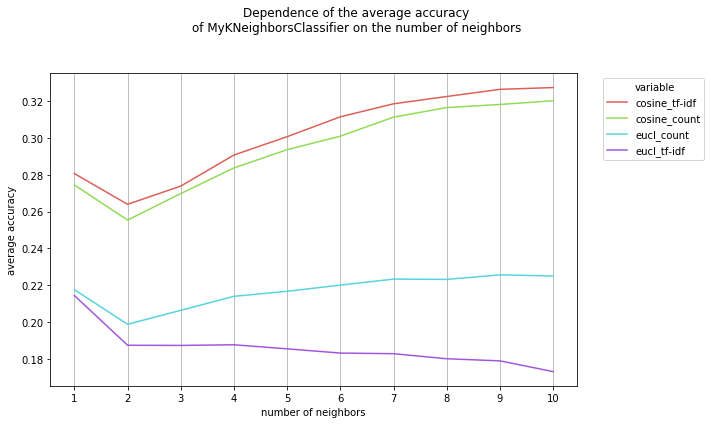

In [29]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Dependence of the average accuracy\nof MyKNeighborsClassifier on the number of neighbors\n\n",
            fontsize=12)
sns.lineplot(x='neigh', y='value', hue='variable', 
             data=pd.melt(accuracy_scores, ['neigh']),
             palette="hls", 
             hue_order=['cosine_tf-idf', 'cosine_count', 'eucl_count', 'eucl_tf-idf'])
plt.xlabel('number of neighbors')
plt.ylabel('average accuracy')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xticks(np.arange(1, 11, step=1))
plt.grid(axis='x', color='grey',linewidth=0.5)
fig.tight_layout(rect=[0, 0.005, 1, 0.85])
plt.show()

In [30]:
# we see that the best choice is to use tf-idf and cosine metrics
best_neigh_num = 10
best_metrics = 'cosine'

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [32]:
from sklearn import metrics

In [33]:
sentence_vectors_tfidf_test = vectorizer_tfidf.transform(data_test)

In [34]:
clf_knn = MyKNeighborsClassifier(n_neighbors=best_neigh_num, metrics=best_metrics)

clf_knn.fit(sentence_vectors_tfidf.toarray(), target)

MyKNeighborsClassifier(algorithm='brute', metrics='cosine', n_neighbors=10)

In [35]:
y_pred_knn = clf_knn.predict(sentence_vectors_tfidf_test.toarray())

In [36]:
metrics.accuracy_score(target_test, y_pred_knn)

0.29235262878385554